# Regresiones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Resultado del mes anterior

In [2]:
imacec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20Imacec.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imacec.columns = ['imacec']
imacec.tail()

,imacec
Fecha,
2020-12-01,-0.071983
2021-01-01,-2.931077
2021-02-01,-2.080374
2021-03-01,5.770488
2021-04-01,14.052287


In [3]:
prediccion = pd.read_csv('pred_2021_05.csv', index_col='percepcion')

In [4]:
# Predicción con encuesta de expectativas económicas
prediccion['imacec'] = imacec['imacec'][-1]
prediccion['abs-error'] = np.abs(prediccion['prediccion'] - prediccion['imacec'])
prediccion.sort_values('abs-error')

,prediccion,imacec,abs-error
percepcion,,,
Encuesta,9.5000,14.052287,4.552287
IMCE,2.1718,14.052287,11.880487
ICE,0.7602,14.052287,13.292087
Empresarios,0.0815,14.052287,13.970787
IPECO,-4.6455,14.052287,18.697787
Todos,-5.2075,14.052287,19.259787
Consumidores,-6.7920,14.052287,20.844287
IPEC,-9.6941,14.052287,23.746387


In [5]:
prediccion = prediccion.drop('Encuesta', axis=0)
prediccion = prediccion.sort_values('abs-error')
prediccion['ranking'] = np.arange(1,8,1)

In [6]:
prediccion.to_csv('res_2021_05.csv')
prediccion.round(2)

,prediccion,imacec,abs-error,ranking
percepcion,,,,
IMCE,2.17,14.05,11.88,1
ICE,0.76,14.05,13.29,2
Empresarios,0.08,14.05,13.97,3
IPECO,-4.65,14.05,18.70,4
Todos,-5.21,14.05,19.26,5
Consumidores,-6.79,14.05,20.84,6
IPEC,-9.69,14.05,23.75,7


# Carga y Preprocesamiento de los datos de percepciones

In [7]:
ipeco = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20IPECO.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipeco.columns = ['ipeco', 'coyuntura', 'expectativas', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if', 'ipeco-m3']
ipeco = ipeco[['ipeco', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if']]
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if
Fecha,,,,,,
2021-01-01,70.941959,56.303419,103.987953,78.534279,76.075351,60.349190
2021-02-01,86.890132,70.970696,137.805173,87.763363,105.542153,69.841868
2021-03-01,80.562027,51.903942,133.211667,82.546979,105.494734,65.929263
2021-04-01,52.248795,35.568193,69.676773,54.504512,63.636364,48.792962
2021-05-01,76.292156,74.233717,104.180711,78.858801,84.644522,62.220483


In [8]:
ipeco['ipeco-m3'] = ipeco['ipeco'].rolling(3).mean()
ipeco['ipeco-m6'] = ipeco['ipeco'].rolling(6).mean()
ipeco['ipeco-presente'] = ipeco[['ipeco-sea', 'ipeco-da']].mean(axis=1)
ipeco['ipeco-futuro'] = ipeco[['ipeco-sef', 'ipeco-df', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-personal'] = ipeco[['ipeco-sea', 'ipeco-sef', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-nacional'] = ipeco[['ipeco-df', 'ipeco-da']].mean(axis=1)
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if,ipeco-m3,ipeco-m6,ipeco-presente,ipeco-futuro,ipeco-personal,ipeco-nacional
Fecha,,,,,,,,,,,,
2021-01-01,70.941959,56.303419,103.987953,78.534279,76.075351,60.349190,72.312649,73.238076,80.145686,71.652940,65.062296,90.031652
2021-02-01,86.890132,70.970696,137.805173,87.763363,105.542153,69.841868,74.940026,75.224536,104.387934,87.715795,76.191975,121.673663
2021-03-01,80.562027,51.903942,133.211667,82.546979,105.494734,65.929263,79.464706,76.783566,92.557805,84.656992,66.793395,119.353201
2021-04-01,52.248795,35.568193,69.676773,54.504512,63.636364,48.792962,73.233652,72.773150,52.622483,55.644613,46.288556,66.656568
2021-05-01,76.292156,74.233717,104.180711,78.858801,84.644522,62.220483,69.700993,72.320509,89.207214,75.241269,71.771000,94.412616


In [9]:
ipec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/GFK%20ADIMARK%20IPEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipec.columns = ['ipec-sepa', 'ipec-sena', 'ipec-senf12m', 'ipec-senf5y', 'ipec-ec', 'ipec']
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec
Fecha,,,,,,
2021-01-01,27.732677,27.048832,37.063938,23.188694,32.412163,29.489262
2021-02-01,29.124720,30.429945,43.852360,23.494522,32.967945,31.973898
2021-03-01,25.384239,28.663019,39.274822,23.418276,29.205111,29.189093
2021-04-01,22.900463,22.300762,34.152779,23.106691,22.041729,24.900484
2021-05-01,28.940214,27.102739,39.096775,23.967649,30.048767,29.831228


In [10]:
ipec['ipec-m3'] = ipec['ipec'].rolling(3).mean()
ipec['ipec-m6'] = ipec['ipec'].rolling(6).mean()
ipec['ipec-presente'] = ipec[['ipec-sepa', 'ipec-sena', 'ipec-ec']].mean(axis=1)
ipec['ipec-futuro'] = ipec[['ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec['ipec-personal'] = ipec[['ipec-sepa', 'ipec-ec']].mean(axis=1)
ipec['ipec-nacional'] = ipec[['ipec-sena', 'ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec,ipec-m3,ipec-m6,ipec-presente,ipec-futuro,ipec-personal,ipec-nacional
Fecha,,,,,,,,,,,,
2021-01-01,27.732677,27.048832,37.063938,23.188694,32.412163,29.489262,29.627104,28.470716,29.064557,30.126316,30.072420,29.100488
2021-02-01,29.124720,30.429945,43.852360,23.494522,32.967945,31.973898,30.436200,29.552789,30.840870,33.673441,31.046332,32.592276
2021-03-01,25.384239,28.663019,39.274822,23.418276,29.205111,29.189093,30.217417,29.994096,27.750790,31.346549,27.294675,30.452039
2021-04-01,22.900463,22.300762,34.152779,23.106691,22.041729,24.900484,28.687825,29.157464,22.414318,28.629735,22.471096,26.520077
2021-05-01,28.940214,27.102739,39.096775,23.967649,30.048767,29.831228,27.973602,29.204901,28.697240,31.532212,29.494491,30.055721


In [11]:
ice = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20ICE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ice.columns = ['ice', 'ice-m3', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']
ice = ice[['ice', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']]
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria
Fecha,,,,,,,
2021-01-01,1.652625,6.844920,7.983970,-21.180036,-3.125000,13.612599,-1.288889
2021-02-01,9.014656,-11.764706,10.674966,-5.529412,25.000000,21.418651,1.833333
2021-03-01,6.794963,12.727273,3.030249,11.961230,-21.875000,8.273810,17.215278
2021-04-01,-3.509817,-17.647059,5.150985,12.183601,-45.833333,15.651290,-15.611111
2021-05-01,0.930573,18.823529,4.975791,-6.157754,-12.500000,6.891369,-2.694444


In [12]:
ice['ice-m'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-m3'] = ice['ice'].rolling(3).mean()
ice['ice-m6'] = ice['ice'].rolling(6).mean()
ice['ice-sagri'] = ice[['ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scom'] = ice[['ice-agricola', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scons'] = ice[['ice-agricola', 'ice-comercio', 'ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sfin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sind'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-mineria']].mean(axis=1)
ice['ice-smin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria']].mean(axis=1)
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria,ice-m,ice-m3,ice-m6,ice-sagri,ice-scom,ice-scons,ice-sfin,ice-sind,ice-smin
Fecha,,,,,,,,,,,,,,,,
2021-01-01,1.652625,6.844920,7.983970,-21.180036,-3.125000,13.612599,-1.288889,0.474594,1.045889,-5.475338,-0.799471,-1.027281,4.805520,1.194513,-2.153007,0.827291
2021-02-01,9.014656,-11.764706,10.674966,-5.529412,25.000000,21.418651,1.833333,6.938805,5.357468,-0.263411,10.679508,6.191573,9.432449,3.326566,4.042836,7.959900
2021-03-01,6.794963,12.727273,3.030249,11.961230,-21.875000,8.273810,17.215278,5.222140,5.820748,2.221103,3.721113,5.660518,3.874322,10.641568,4.611806,2.823512
2021-04-01,-3.509817,-17.647059,5.150985,12.183601,-45.833333,15.651290,-15.611111,-7.684271,4.099934,2.572912,-5.691714,-10.251323,-11.657846,-0.054459,-12.351384,-6.098903
2021-05-01,0.930573,18.823529,4.975791,-6.157754,-12.500000,6.891369,-2.694444,1.556415,1.405240,3.381354,-1.897008,0.872540,3.099249,4.367698,0.489424,2.406587


In [13]:
imce = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/ICARE%20UAI%20IMCE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imce.columns = ['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce', 'imce-sm']
imce = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce']]
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce
Fecha,,,,,
2021-01-01,56.956522,40.079365,54.395604,64.879038,54.379643
2021-02-01,58.404558,44.230769,56.105611,62.604000,55.721718
2021-03-01,61.016949,48.550725,58.108108,51.730401,55.875158
2021-04-01,56.533333,44.791667,52.212389,49.474696,51.416693
2021-05-01,58.539945,40.000000,56.327160,61.676281,54.883423


In [14]:
imce['imce-m'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-m3'] = imce['imce'].rolling(3).mean()
imce['imce-m6'] = imce['imce'].rolling(6).mean()
imce['imce-scom'] = imce[['imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-scons'] = imce[['imce-comercio', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-sind'] = imce[['imce-comercio', 'imce-construccion', 'imce-mineria']].mean(axis=1)
imce['imce-smin'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria']].mean(axis=1)
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce,imce-m,imce-m3,imce-m6,imce-scom,imce-scons,imce-sind,imce-smin
Fecha,,,,,,,,,,,,
2021-01-01,56.956522,40.079365,54.395604,64.879038,54.379643,54.077632,52.180232,50.091201,53.118003,58.743721,53.971642,50.477164
2021-02-01,58.404558,44.230769,56.105611,62.604000,55.721718,55.336234,52.700608,52.292919,54.313460,59.038056,55.079776,52.913646
2021-03-01,61.016949,48.550725,58.108108,51.730401,55.875158,54.851546,55.325506,53.303742,52.796411,56.951820,53.766025,55.891927
2021-04-01,56.533333,44.791667,52.212389,49.474696,51.416693,50.753021,54.337856,53.259044,48.826251,52.740140,50.266565,51.179130
2021-05-01,58.539945,40.000000,56.327160,61.676281,54.883423,54.135847,54.058424,53.379516,52.667814,58.847796,53.405409,51.622368


In [15]:
encuesta = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20EEE%20PIB%20e%20IMACEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
encuesta = encuesta[['IMACEC un mes atrás']]
encuesta.columns = ['encuesta-imacec']
encuesta['encuesta-imacec'] = encuesta['encuesta-imacec'].shift(-1)
encuesta.tail()

,encuesta-imacec
Fecha,
2021-01-01,-1.0
2021-02-01,-1.5
2021-03-01,1.6
2021-04-01,9.5
2021-05-01,NaN


In [16]:
data = pd.concat([imacec, ipeco, ipec, ice, imce], axis=1)
print(data.shape)
data.tail()

(305, 53)


,imacec,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if,ipeco-m3,ipeco-m6,ipeco-presente,...,imce-industria,imce-mineria,imce,imce-m,imce-m3,imce-m6,imce-scom,imce-scons,imce-sind,imce-smin
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-01-01,-2.931077,70.941959,56.303419,103.987953,78.534279,76.075351,60.349190,72.312649,73.238076,80.145686,...,54.395604,64.879038,54.379643,54.077632,52.180232,50.091201,53.118003,58.743721,53.971642,50.477164
2021-02-01,-2.080374,86.890132,70.970696,137.805173,87.763363,105.542153,69.841868,74.940026,75.224536,104.387934,...,56.105611,62.604000,55.721718,55.336234,52.700608,52.292919,54.313460,59.038056,55.079776,52.913646
2021-03-01,5.770488,80.562027,51.903942,133.211667,82.546979,105.494734,65.929263,79.464706,76.783566,92.557805,...,58.108108,51.730401,55.875158,54.851546,55.325506,53.303742,52.796411,56.951820,53.766025,55.891927
2021-04-01,14.052287,52.248795,35.568193,69.676773,54.504512,63.636364,48.792962,73.233652,72.773150,52.622483,...,52.212389,49.474696,51.416693,50.753021,54.337856,53.259044,48.826251,52.740140,50.266565,51.179130
2021-05-01,NaN,76.292156,74.233717,104.180711,78.858801,84.644522,62.220483,69.700993,72.320509,89.207214,...,56.327160,61.676281,54.883423,54.135847,54.058424,53.379516,52.667814,58.847796,53.405409,51.622368


# Preprocesamiento, funciones y dataframes para guardar los resultados

In [17]:
# Función para calcular las métricas de evaluación. 
def get_metrics(indice, y_test, y_pred):
    return pd.DataFrame({
                'CV_RMSE': np.sqrt(np.abs(searcher.best_score_)),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'R2': r2_score(y_test, y_pred)},
                index=[indice])

In [18]:
# DataFrames vacíos para almacenar los resultados 
results = pd.DataFrame()
parametros = pd.DataFrame()
samples = pd.DataFrame()

In [19]:
# Variables X e y
X = data.drop(['imacec'], axis=1)
y = data['imacec']

In [20]:
# Train y Test sets
X_train0 = X.iloc[:-1]
X_test0 = X.iloc[[-1]]
y_train0 = y.iloc[:-1]

print(
    'X_train shape:', X_train0.shape,
    'X_test shape:', X_test0.shape,
    'y_train shape:', y_train0.shape)

X_train shape: (304, 52) X_test shape: (1, 52) y_train shape: (304,)


In [21]:
def gen_X_train(variables):
    X_train = X_train0[variables].dropna()
    X_test = X_test0[variables]
    y_train = y_train0[X_train.index]
    print('X_train shape:', X_train.shape, '||', 'X_test shape:', X_test.shape, '||', 'y_train shape:', y_train.shape)

    return X_train, X_test, y_train

In [22]:
# Variables de cada modelo
vipeco = ipeco.columns
vipec = ipec.columns
vice = ice.columns
vimce = imce.columns
vconsumidores = ipeco.columns.append(ipec.columns)
vempresarios = ice.columns.append(imce.columns)


# IPECO

In [23]:
indice = 'IPECO'
X_train, X_test, y_train = gen_X_train(vipeco)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))

X_train shape: (201, 12) || X_test shape: (1, 12) || y_train shape: (201,)


In [24]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
parametros = parametros.append(pd.DataFrame(searcher.best_params_, index=[indice]))

best_model = searcher.best_estimator_
y_train_pred = best_model.predict(X_train)

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:07:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 12, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,3.0968,1.7864,1.127,0.7915


# IPEC

In [25]:
indice = 'IPEC'
X_train, X_test, y_train = gen_X_train(vipec)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))

X_train shape: (225, 12) || X_test shape: (1, 12) || y_train shape: (225,)


In [26]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
parametros = parametros.append(pd.DataFrame(searcher.best_params_, index=[indice]))

best_model = searcher.best_estimator_
y_train_pred = best_model.predict(X_train)

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:07:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 12, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,3.0968,1.7864,1.1270,0.7915
IPEC,3.6549,2.0824,1.3602,0.7026


# ICE

In [27]:
indice = 'ICE'
X_train, X_test, y_train = gen_X_train(vice)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))

X_train shape: (190, 16) || X_test shape: (1, 16) || y_train shape: (190,)


In [28]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
parametros = parametros.append(pd.DataFrame(searcher.best_params_, index=[indice]))

best_model = searcher.best_estimator_
y_train_pred = best_model.predict(X_train)

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 12, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,3.0968,1.7864,1.1270,0.7915
IPEC,3.6549,2.0824,1.3602,0.7026
ICE,3.3867,1.4520,1.0286,0.8643


# IMCE

In [29]:
indice = 'IMCE'
X_train, X_test, y_train = gen_X_train(vimce)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))

X_train shape: (205, 12) || X_test shape: (1, 12) || y_train shape: (205,)


In [30]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
parametros = parametros.append(pd.DataFrame(searcher.best_params_, index=[indice]))

best_model = searcher.best_estimator_
y_train_pred = best_model.predict(X_train)

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:07:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,3.0968,1.7864,1.1270,0.7915
IPEC,3.6549,2.0824,1.3602,0.7026
ICE,3.3867,1.4520,1.0286,0.8643
IMCE,3.1089,0.8934,0.6520,0.9497


# Confianza de los consumidores

In [31]:
indice = 'Consumidores'
X_train, X_test, y_train = gen_X_train(vconsumidores)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))

X_train shape: (201, 24) || X_test shape: (1, 24) || y_train shape: (201,)


In [32]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.35, 0.5, 0.67],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
parametros = parametros.append(pd.DataFrame(searcher.best_params_, index=[indice]))

best_model = searcher.best_estimator_
y_train_pred = best_model.predict(X_train)

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
[14:07:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.35, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,3.0968,1.7864,1.1270,0.7915
IPEC,3.6549,2.0824,1.3602,0.7026
ICE,3.3867,1.4520,1.0286,0.8643
IMCE,3.1089,0.8934,0.6520,0.9497
Consumidores,3.2951,1.1466,0.7752,0.9141


# Confianza empresarial

In [33]:
indice = 'Empresarios'
X_train, X_test, y_train = gen_X_train(vempresarios)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))

X_train shape: (190, 28) || X_test shape: (1, 28) || y_train shape: (190,)


In [34]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.35, 0.5, 0.67],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
parametros = parametros.append(pd.DataFrame(searcher.best_params_, index=[indice]))

best_model = searcher.best_estimator_
y_train_pred = best_model.predict(X_train)

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
[14:07:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.67, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,3.0968,1.7864,1.1270,0.7915
IPEC,3.6549,2.0824,1.3602,0.7026
ICE,3.3867,1.4520,1.0286,0.8643
IMCE,3.1089,0.8934,0.6520,0.9497
Consumidores,3.2951,1.1466,0.7752,0.9141
Empresarios,3.2158,1.1321,0.8014,0.9175


# Todos los índices

In [35]:
indice = 'Todos'
X_train, X_test, y_train = gen_X_train(X_train0.columns)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))

X_train shape: (190, 52) || X_test shape: (1, 52) || y_train shape: (190,)


In [36]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.17, 0.34, 0.5, 0.75],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)
parametros = parametros.append(pd.DataFrame(searcher.best_params_, index=[indice]))

best_model = searcher.best_estimator_
y_train_pred = best_model.predict(X_train)

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
[14:07:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.75, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,3.0968,1.7864,1.1270,0.7915
IPEC,3.6549,2.0824,1.3602,0.7026
ICE,3.3867,1.4520,1.0286,0.8643
IMCE,3.1089,0.8934,0.6520,0.9497
Consumidores,3.2951,1.1466,0.7752,0.9141
Empresarios,3.2158,1.1321,0.8014,0.9175
Todos,2.9244,0.5990,0.4318,0.9769


# Evaluación parcial según resultados en CV y train set

In [37]:
samples

,rows,cols
IPECO,201,12
IPEC,225,12
ICE,190,16
IMCE,205,12
Consumidores,201,24
Empresarios,190,28
Todos,190,52


In [38]:
parametros

,colsample_bytree,eta,max_depth,min_child_weight,n_estimators
IPECO,1.00,0.01,3,12,100
IPEC,1.00,0.01,2,12,100
ICE,0.50,0.01,2,12,100
IMCE,1.00,0.01,4,9,100
Consumidores,0.35,0.01,3,9,100
Empresarios,0.67,0.01,2,9,100
Todos,0.75,0.01,3,9,100


In [39]:
results.round(4)

,CV_RMSE,RMSE,MAE,R2
IPECO,3.0968,1.7864,1.1270,0.7915
IPEC,3.6549,2.0824,1.3602,0.7026
ICE,3.3867,1.4520,1.0286,0.8643
IMCE,3.1089,0.8934,0.6520,0.9497
Consumidores,3.2951,1.1466,0.7752,0.9141
Empresarios,3.2158,1.1321,0.8014,0.9175
Todos,2.9244,0.5990,0.4318,0.9769


In [54]:
print('Best models:')
print(results[['CV_RMSE', 'RMSE', 'MAE']].idxmin(), '\n')
print('Best R2:')
print(results['R2'].idxmax(), '\n')
results.round(2)

Best models:
CV_RMSE    Todos
RMSE       Todos
MAE        Todos
dtype: object 

Best R2:
Todos 



,CV_RMSE,RMSE,MAE,R2
IPECO,3.10,1.79,1.13,0.79
IPEC,3.65,2.08,1.36,0.70
ICE,3.39,1.45,1.03,0.86
IMCE,3.11,0.89,0.65,0.95
Consumidores,3.30,1.15,0.78,0.91
Empresarios,3.22,1.13,0.80,0.92
Todos,2.92,0.60,0.43,0.98


In [41]:
(results['CV_RMSE'] / results['RMSE']).round(2)

IPECO           1.73
IPEC            1.76
ICE             2.33
IMCE            3.48
Consumidores    2.87
Empresarios     2.84
Todos           4.88
dtype: float64

# Ajuste de los modelos con muestra completa

In [42]:
parametros

,colsample_bytree,eta,max_depth,min_child_weight,n_estimators
IPECO,1.00,0.01,3,12,100
IPEC,1.00,0.01,2,12,100
ICE,0.50,0.01,2,12,100
IMCE,1.00,0.01,4,9,100
Consumidores,0.35,0.01,3,9,100
Empresarios,0.67,0.01,2,9,100
Todos,0.75,0.01,3,9,100


In [43]:
predicciones = pd.DataFrame()

X_train shape: (201, 12) || X_test shape: (1, 12) || y_train shape: (201,)
[14:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


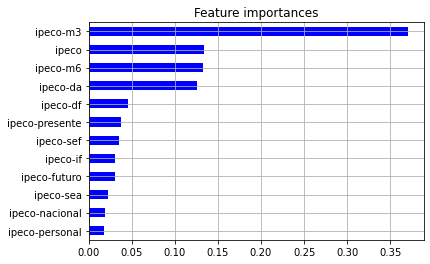

In [44]:
indice = 'IPECO'
X_train, X_test, y_train = gen_X_train(vipeco)

model = xgb.XGBRegressor(colsample_bytree=parametros.loc[indice][0], 
                        eta=parametros.loc[indice][1],  
                        max_depth=parametros.loc[indice][2].astype(int), 
                        min_child_weight=parametros.loc[indice][3].astype(int), 
                        n_estimators=parametros.loc[indice][4].astype(int))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

importances_xgcl = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_importances_xgcl = importances_xgcl.sort_values()
sorted_importances_xgcl.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()


X_train shape: (225, 12) || X_test shape: (1, 12) || y_train shape: (225,)
[14:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


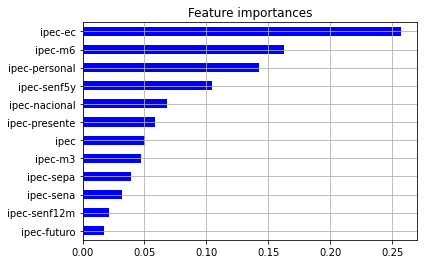

In [45]:
indice = 'IPEC'
X_train, X_test, y_train = gen_X_train(vipec)

model = xgb.XGBRegressor(colsample_bytree=parametros.loc[indice][0], 
                        eta=parametros.loc[indice][1],  
                        max_depth=parametros.loc[indice][2].astype(int), 
                        min_child_weight=parametros.loc[indice][3].astype(int), 
                        n_estimators=parametros.loc[indice][4].astype(int))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

importances_xgcl = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_importances_xgcl = importances_xgcl.sort_values()
sorted_importances_xgcl.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

X_train shape: (190, 16) || X_test shape: (1, 16) || y_train shape: (190,)
[14:24:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


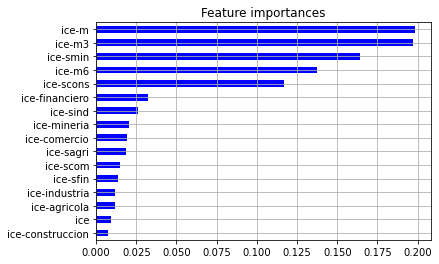

In [46]:
indice = 'ICE'
X_train, X_test, y_train = gen_X_train(vice)

model = xgb.XGBRegressor(colsample_bytree=parametros.loc[indice][0], 
                        eta=parametros.loc[indice][1],  
                        max_depth=parametros.loc[indice][2].astype(int), 
                        min_child_weight=parametros.loc[indice][3].astype(int), 
                        n_estimators=parametros.loc[indice][4].astype(int))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

importances_xgcl = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_importances_xgcl = importances_xgcl.sort_values()
sorted_importances_xgcl.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

X_train shape: (205, 12) || X_test shape: (1, 12) || y_train shape: (205,)
[14:24:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


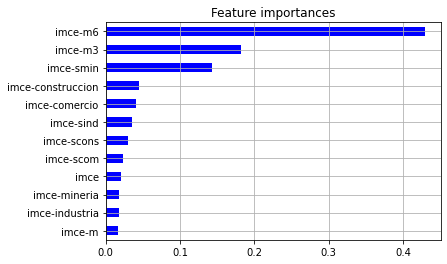

In [47]:
indice = 'IMCE'
X_train, X_test, y_train = gen_X_train(vimce)

model = xgb.XGBRegressor(colsample_bytree=parametros.loc[indice][0], 
                        eta=parametros.loc[indice][1],  
                        max_depth=parametros.loc[indice][2].astype(int), 
                        min_child_weight=parametros.loc[indice][3].astype(int), 
                        n_estimators=parametros.loc[indice][4].astype(int))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

importances_xgcl = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_importances_xgcl = importances_xgcl.sort_values()
sorted_importances_xgcl.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

X_train shape: (201, 24) || X_test shape: (1, 24) || y_train shape: (201,)
[14:42:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


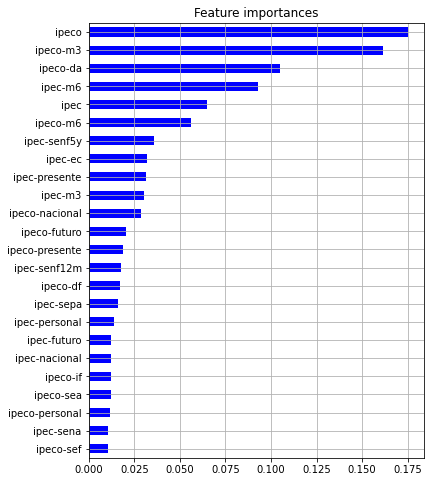

In [64]:
indice = 'Consumidores'
X_train, X_test, y_train = gen_X_train(vconsumidores)

model = xgb.XGBRegressor(colsample_bytree=parametros.loc[indice][0], 
                        eta=parametros.loc[indice][1],  
                        max_depth=parametros.loc[indice][2].astype(int), 
                        min_child_weight=parametros.loc[indice][3].astype(int), 
                        n_estimators=parametros.loc[indice][4].astype(int))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

importances_xgcl = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_importances_xgcl = importances_xgcl.sort_values()
sorted_importances_xgcl.plot(kind='barh', color='blue', figsize=(6,8))
plt.title('Feature importances')
plt.grid()
plt.show()

X_train shape: (190, 28) || X_test shape: (1, 28) || y_train shape: (190,)
[14:42:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


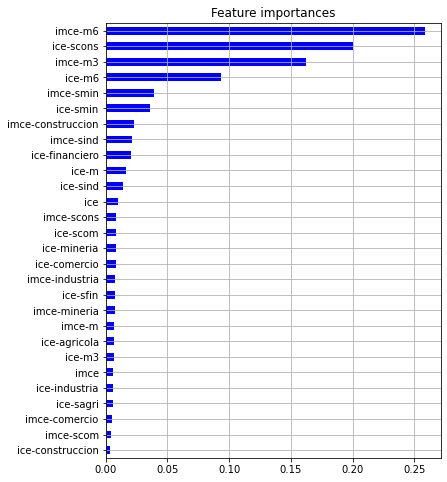

In [65]:
indice = 'Empresarios'
X_train, X_test, y_train = gen_X_train(vempresarios)

model = xgb.XGBRegressor(colsample_bytree=parametros.loc[indice][0], 
                        eta=parametros.loc[indice][1],  
                        max_depth=parametros.loc[indice][2].astype(int), 
                        min_child_weight=parametros.loc[indice][3].astype(int), 
                        n_estimators=parametros.loc[indice][4].astype(int))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

importances_xgcl = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_importances_xgcl = importances_xgcl.sort_values()
sorted_importances_xgcl.plot(kind='barh', color='blue', figsize=(6,8))
plt.title('Feature importances')
plt.grid()
plt.show()

X_train shape: (190, 52) || X_test shape: (1, 52) || y_train shape: (190,)
[14:43:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


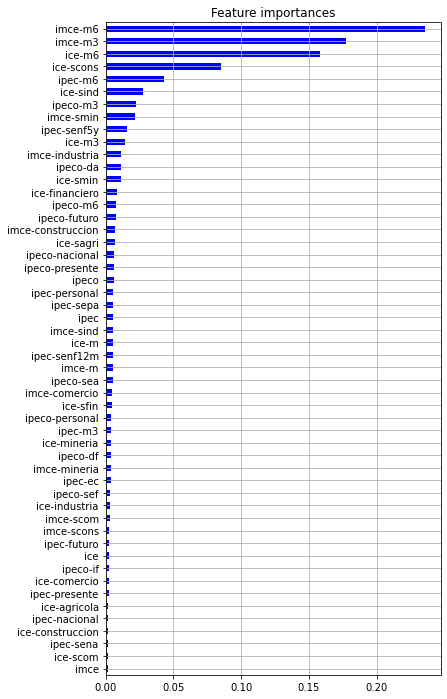

In [67]:
indice = 'Todos'
X_train, X_test, y_train = gen_X_train(X_train0.columns)

model = xgb.XGBRegressor(colsample_bytree=parametros.loc[indice][0], 
                        eta=parametros.loc[indice][1],  
                        max_depth=parametros.loc[indice][2].astype(int), 
                        min_child_weight=parametros.loc[indice][3].astype(int), 
                        n_estimators=parametros.loc[indice][4].astype(int))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

importances_xgcl = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_importances_xgcl = importances_xgcl.sort_values()
sorted_importances_xgcl.plot(kind='barh', color='blue', figsize=(6,12))
plt.title('Feature importances')
plt.grid()
plt.show()

In [51]:
predicciones.round(4)

,Imacec
IPECO,-0.6485
IPEC,0.9353
ICE,4.7326
IMCE,3.1316
Consumidores,1.0639
Empresarios,3.8945
Todos,5.2159


In [52]:
print('Mayor predicción:')
print(predicciones['Imacec'].idxmax(), '\n')

print('Menor predicción:')
print(predicciones['Imacec'].idxmin(), '\n')

Mayor predicción:
Todos 

Menor predicción:
IPECO 



In [53]:
predicciones.to_csv('pred_2021_06.csv')